# Set up SuPy for Your Own Site


This tutorial aims to demonstrate how to set up SuPy for your own site to model the surface energy balance (SEB).

Please note: [SuPy](https://supy.readthedocs.io/) is a Python-enhanced urban climate model with [SUEWS, *Surface Urban Energy and Water Balance Scheme*](https://suews.readthedocs.io/), as its computation core.

**We thus strongly recommend/encourage users to have a good understanding of SUEWS first before diving into the SuPy world.**

**Modern Configuration Approach:**

⚠️ **Note**: This tutorial demonstrates the legacy approach of modifying pandas DataFrames. The modern SUEWS approach uses YAML configuration files that provide better structure, validation, and documentation.

For new projects, consider using:
- **Configuration Builder**: Interactive web tool at `docs/source/_static/index.html`
- **YAML configurations**: Type-safe, hierarchical parameter organisation
- **Automated validation**: Built-in parameter checking and scientific references

This tutorial remains valuable for understanding SUEWS parameters and for users migrating from legacy workflows.

In this tutorial, We will use an [AmeriFlux](https://ameriflux.lbl.gov) site [US-AR1](https://doi.org/10.17190/AMF/1246137) as example: 

starting by preparation of input data, we show how to specify site characteristics and choose proper scheme options, then conduct simulations, finally provide some demo figures to help understand the simulation results.



A brief structure is as follows:


1. [Preparing the input data](#Prepare-input-data);
2. [Running a simulation](#Run-simulations);
3. [Examination of results](#Examine-results); and
4. [Further exploration](#More-explorations-into-simulation-results)



## Boilerplate code

In [1]:
import matplotlib.pyplot as plt
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline

## Prepare input data

### Site-specific configuration of surface parameters

Given `pandas.DataFrame` as the core data structure of SuPy, all operations, including modification, output, demonstration, etc., on SuPy inputs (`df_state_init` and `df_forcing`) can be done using `pandas`-based functions/methods.
Please see [SuPy quickstart](https://supy.readthedocs.io/en/latest/tutorial/quick-start.html#Modification-of-SuPy-input) for methods to do so.

Below we will modify several key properties of the chosen site with appropriate values to run SuPy.
First, we copy the `df_state_init` to have a new DataFrame for manipulation.

In [2]:
# Load sample data using modern API
df_state_init, df_forcing = sp.load_sample_data()
df_state_amf = df_state_init.copy()

print("📊 Sample data loaded successfully!")
print("✅ Using modern load_sample_data() API")
print("ℹ️  Will be modified for site-specific configuration")

2025-06-15 23:28:10,679 - SuPy - INFO - Loading config from yaml
📊 Sample data loaded successfully!
✅ Using modern load_sample_data() API
ℹ️  Will be modified for site-specific configuration


In [3]:
# site identifier
name_site = "US-AR1"

Details for determining the proper values of selected physical parameters can be found [here](https://suews-parameters-docs.readthedocs.io/en/latest/).

#### location

In [4]:
# latitude
df_state_amf.loc[:, "lat"] = 41.37
# longitude
df_state_amf.loc[:, "lng"] = -106.24
# altitude
df_state_amf.loc[:, "alt"] = 611.0

#### land cover fraction

[Land covers in SUEWS](https://suews.readthedocs.io/en/latest/introduction.html)

In [5]:
# view the surface fraction variable: `sfr_surf`
df_state_amf.loc[:, "sfr_surf"] = 0
df_state_amf.loc[:, ("sfr_surf", "(4,)")] = 1
df_state_amf.loc[:, "sfr_surf"]

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0,0,0,0,1,0,0


#### albedo

In [6]:
# we only set values for grass as the modelled site has a single land cover type: grass.
df_state_amf.albmax_grass = 0.19
df_state_amf.albmin_grass = 0.14

In [7]:
# initial albedo value
df_state_amf.loc[:, "albgrass_id"] = 0.14

#### LAI/phenology

In [8]:
df_state_amf.filter(like="lai")

var     lai_id           laimax           laimin           laipower  ...  \
ind_dim   (0,) (1,) (2,)   (0,) (1,) (2,)   (0,) (1,) (2,)   (0, 0)  ...   
grid                                                                 ...   
1          4.0  1.0  1.6    5.1  5.5  5.9    4.0  1.0  1.6     0.04  ...   

var                                                         laitype            
ind_dim (1, 2) (2, 0) (2, 1) (2, 2)  (3, 0)  (3, 1)  (3, 2)    (0,) (1,) (2,)  
grid                                                                           
1        0.001   -1.5   -1.5   -1.5  0.0015  0.0015  0.0015       1    1    1  

[1 rows x 24 columns]

In [9]:
# properties to control vegetation phenology
# you can skip the details for and just set them as provided below

# LAI paramters
df_state_amf.loc[:, ("laimax", "(2,)")] = 1
df_state_amf.loc[:, ("laimin", "(2,)")] = 0.2
# initial LAI
df_state_amf.loc[:, ("lai_id", "(2,)")] = 0.2

# BaseT
df_state_amf.loc[:, ("baset", "(2,)")] = 5
# BaseTe
df_state_amf.loc[:, ("basete", "(2,)")] = 20

# SDDFull
df_state_amf.loc[:, ("sddfull", "(2,)")] = -1000
# GDDFull
df_state_amf.loc[:, ("gddfull", "(2,)")] = 1000

#### surface resistance

In [10]:
# parameters to model surface resistance
df_state_amf.maxconductance = 18.7
df_state_amf.g1 = 1
df_state_amf.g2 = 104.215
df_state_amf.g3 = 0.424
df_state_amf.g4 = 0.814
df_state_amf.g5 = 36.945
df_state_amf.g6 = 0.025

#### measurement height

In [11]:
# height where forcing variables are measured/collected
df_state_amf.z = 2.84

#### urban feature

In [12]:
# disable anthropogenic heat by setting zero population
df_state_amf.popdensdaytime = 0
df_state_amf.popdensnighttime = 0

#### check `df_state`

In [13]:
# this procedure is to double-check proper values are set in `df_state_amf`
sp.check_state(df_state_amf)

2025-06-15 23:28:13,091 - SuPy - INFO - SuPy is validating `df_state`...
2025-06-15 23:28:13,185 - SuPy - ERROR - Issues found in `df_state`:
Mandatory parameters missing from rule file: {np.str_('windowinternalemissivity'), np.str_('watertankwallthickness'), np.str_('wallinternalconvectioncoefficient'), np.str_('wallabsorbtivity'), np.str_('internalmassemissivity'), np.str_('dhwvesselemissivity'), np.str_('groundflooreffectiveconductivity'), np.str_('internalmasscp'), np.str_('windowindoorsurfacetemperature'), np.str_('stebbs_height'), np.str_('groundflooroutdoorsurfacetemperature'), np.str_('externalwallwatertanktemperature'), np.str_('hotwaterflowrate'), np.str_('windowabsorbtivity'), np.str_('wallexternalemissivity'), np.str_('indooraircp'), np.str_('footprintarea'), np.str_('walldensity'), np.str_('domestichotwatertemperatureinuseinbuilding'), np.str_('watertanktemperature'), np.str_('windowthickness'), np.str_('windowoutdoorsurfacetemperature'), np.str_('hotwaterheatingsetpointte

var     ah_min       ah_slope_cooling      ah_slope_heating      ahprof_24hr  \
ind_dim   (0,)  (1,)             (0,) (1,)             (0,) (1,)      (0, 0)   
grid                                                                           
1         15.0  15.0              2.7  2.7              2.7  2.7        0.57   

var                           ... wuprofm_24hr                          \
ind_dim (0, 1) (1, 0) (1, 1)  ...      (21, 0) (21, 1) (22, 0) (22, 1)   
grid                          ...                                        
1         0.65   0.45   0.49  ...       -999.0  -999.0  -999.0  -999.0   

var                      wwr     z z0m_in zdm_in  
ind_dim (23, 0) (23, 1)    0     0      0      0  
grid                                              
1        -999.0  -999.0  0.2  2.84    1.9   14.2  

[1 rows x 1396 columns]

### prepare forcing conditions

Here we use the SuPy utility function `read_forcing` to read in forcing data from an external file in the format of SUEWS input.
Also note, this `read_forcing` utility will also resample the forcing data to a proper temporal resolution to run SuPy/SUEWS, which is usually 5 min (300 s).

#### load and resample forcing data

<div class="alert alert-info">

UMEP workshop users: please note the AMF file path might be DIFFERENT from yours; please set it to the location where your downloaded file is placed.

</div>

In [14]:
# load forcing data from an external file and resample to a resolution of 300 s.
# Note this dataset has been gap-filled.
df_forcing_amf = sp.util.read_forcing("data/US-AR1_2010_data_60.txt", tstep_mod=300)

# this procedure is to double-check proper forcing values are set in `df_forcing_amf`
_ = sp.check_forcing(df_forcing_amf)

2025-06-15 23:28:14,295 - SuPy - INFO - SuPy is validating `df_forcing`...
2025-06-15 23:28:14,390 - SuPy - ERROR - Issues found in `df_forcing`:
`kdown` should be between [0, 1400] but 45108 outliers are found at:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 3

The checker detected invalid values in variable `kdown`: negative incoming solar radiation is found. We then need to fix this as follows:

In [15]:
# modify invalid values
df_forcing_amf.kdown = df_forcing_amf.kdown.where(df_forcing_amf.kdown > 0, 0)

In [16]:
# check `df_forcing` again
_ = sp.check_forcing(df_forcing_amf)

2025-06-15 23:28:14,404 - SuPy - INFO - SuPy is validating `df_forcing`...
2025-06-15 23:28:14,471 - SuPy - INFO - All checks for `df_forcing` passed!


#### examine forcing data

We can examine the forcing data:

In [17]:
list_var_forcing = [
    "kdown",
    "Tair",
    "RH",
    "pres",
    "U",
    "rain",
]
dict_var_label = {
    "kdown": "Incoming Solar\n Radiation ($ \mathrm{W \ m^{-2}}$)",
    "Tair": "Air Temperature ($^{\circ}$C)",
    "RH": r"Relative Humidity (%)",
    "pres": "Air Pressure (hPa)",
    "rain": "Rainfall (mm)",
    "U": "Wind Speed (m $\mathrm{s^{-1}}$)",
}
df_plot_forcing_x = (
    df_forcing_amf.loc[:, list_var_forcing].copy().shift(-1).dropna(how="any")
)
df_plot_forcing = df_plot_forcing_x.resample("1h").mean()
df_plot_forcing["rain"] = df_plot_forcing_x["rain"].resample("1h").sum()


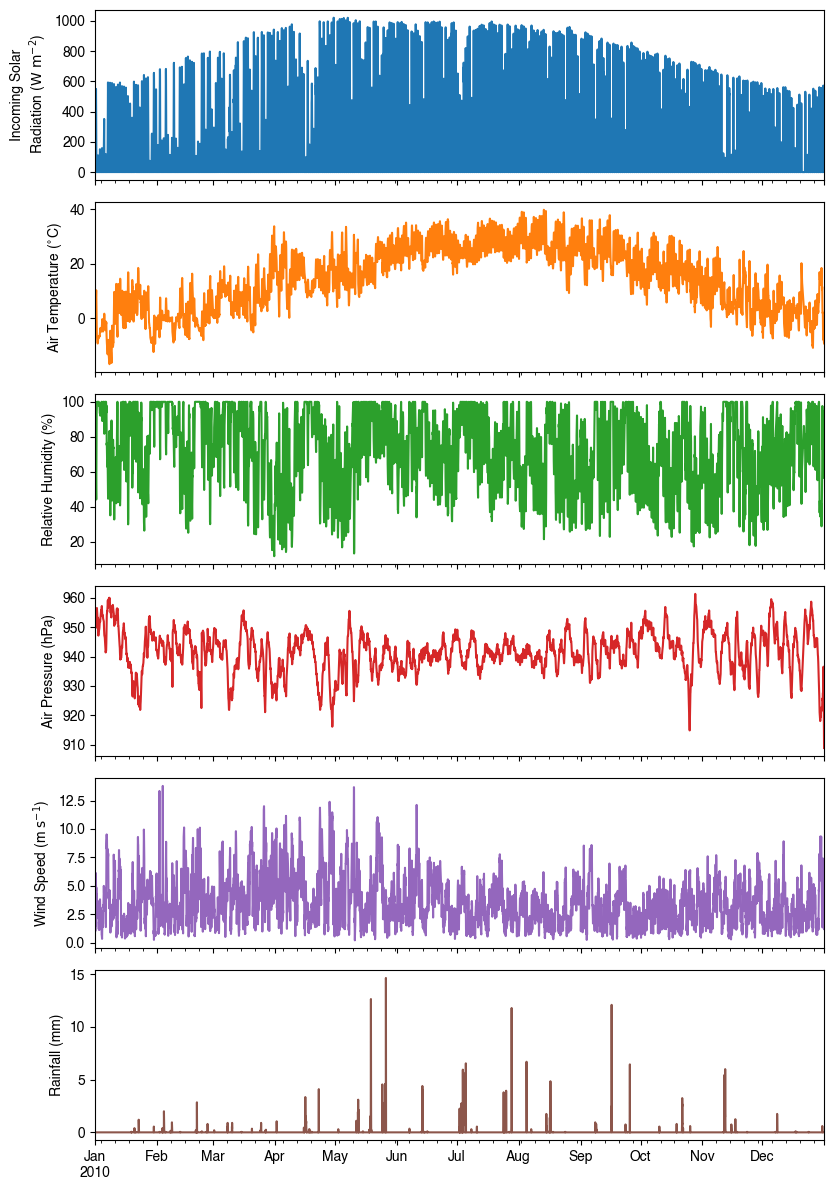

In [18]:
axes = df_plot_forcing.plot(
    subplots=True,
    figsize=(8, 12),
    legend=False,
)
fig = axes[0].figure
fig.tight_layout()
for ax, var in zip(axes, list_var_forcing):
    _ = ax.set_ylabel(dict_var_label[var])

## Run simulations

Once met-forcing (via `df_forcing_amf`) and initial conditions (via `df_state_amf`) are loaded in, we call `sp.run_supy` to conduct a SUEWS simulation, which will return two `pandas` `DataFrame`s: `df_output` and `df_state_final`.

In [19]:
sp.check_forcing(df_forcing)

2025-06-15 23:28:32,439 - SuPy - INFO - SuPy is validating `df_forcing`...
2025-06-15 23:28:32,456 - SuPy - INFO - All checks for `df_forcing` passed!


In [ ]:
df_output, df_state_final = sp.run_supy(df_forcing_amf, df_state_amf)

### `df_output`

`df_output` is an ensemble output collection of major SUEWS output groups, including:

* SUEWS: the essential SUEWS output variables
* DailyState: variables of daily state information
* snow: snow output variables (effective when `snowuse = 1` set in `df_state_init`)
* RSL: profile of air temperature, humidity and wind speed within roughness sub-layer.

Detailed description of variables in `df_output` refers to [SuPy output](../data-structure/supy-io.html#df_output:-model-output-results)

In [ ]:
df_output.columns.levels[0]

### `df_state_final`

`df_state_final` is a `DataFrame` for holding:

1. all model states if `save_state` is set to `True` when calling `sp.run_supy` (`supy` may run significantly slower for a large simulations);
2. or, only the final state if `save_state` is set to `False` (the default setting) in which mode `supy` has a similar performance as the standalone compiled SUEWS executable.

Entries in `df_state_final` have the same data structure as `df_state_init` and can thus be used for other SUEWS simulations staring at the timestamp as in `df_state_final`.

Detailed description of variables in `df_state_final` refers to [SuPy output](../data-structure/supy-io.html#df_state_final:-model-final-states)

In [ ]:
df_state_final.T.head()

## Examine results

Thanks to the functionality inherited from `pandas` and other packages under the [PyData](https://pydata.org) stack, compared with the standard SUEWS simulation workflow, `supy` enables more convenient examination of SUEWS results by statistics calculation, resampling, plotting (and many more).

### Ouptut structure

`df_output` is organised with `MultiIndex` `(grid,timestamp)` and `(group,varaible)` as `index` and `columns`, respectively.

In [ ]:
df_output.head()

Here we demonstrate several typical scenarios for SUEWS results examination.

The essential `SUEWS` output collection is extracted as a separate variable for easier processing in the following sections. More [advanced slicing techniques](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing) are available in `pandas` documentation.

In [23]:
grid = df_state_amf.index[0]
df_output_suews = df_output.loc[grid, "SUEWS"]

### Statistics Calculation

We can use `.describe()` method for a quick overview of the key surface energy balance budgets.

In [ ]:
df_output_suews.loc[:, ["QN", "QS", "QH", "QE", "QF"]].describe()

### Plotting

#### Basic example
Plotting is very straightforward via the `.plot` method bounded with `pandas.DataFrame`.
Note the usage of `loc` for to slices of the output `DataFrame`.

In [25]:
# a dict for better display variable names
dict_var_disp = {
    "QN": "$Q^*$",
    "QS": r"$\Delta Q_S$",
    "QE": "$Q_E$",
    "QH": "$Q_H$",
    "QF": "$Q_F$",
    "Kdown": r"$K_{\downarrow}$",
    "Kup": r"$K_{\uparrow}$",
    "Ldown": r"$L_{\downarrow}$",
    "Lup": r"$L_{\uparrow}$",
    "Rain": "$P$",
    "Irr": "$I$",
    "Evap": "$E$",
    "RO": "$R$",
    "TotCh": "$\Delta S$",
}

Peek at the simulation results:

In [26]:
grid = df_state_init.index[0]

In [ ]:
ax_output = (
    df_output_suews.loc["2010-06-01":"2010-06-07", ["QN", "QS", "QE", "QH", "QF"]]
    .rename(columns=dict_var_disp)
    .plot()
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Flux ($ \mathrm{W \ m^{-2}}$)")
_ = ax_output.legend()

#### Plotting after resampling

The suggested runtime/simulation frequency of SUEWS is `300 s`, which usually results in a large output and may be over-weighted for storage and analysis. 
Also, you may feel an apparent slowdown in producing the above figure as a large amount of data were used for the plotting.
To slim down the result size for analysis and output, we can `resample` the default output very easily.

In [28]:
rsmp_1d = df_output_suews.resample("1d")
# daily mean values
df_1d_mean = rsmp_1d.mean()
# daily sum values
df_1d_sum = rsmp_1d.sum()

We can then re-examine the above energy balance at hourly scale and plotting will be significantly faster.

In [ ]:
# energy balance
ax_output = (
    df_1d_mean.loc[:, ["QN", "QS", "QE", "QH", "QF"]]
    .rename(columns=dict_var_disp)
    .plot(
        figsize=(10, 3),
        title="Surface Energy Balance",
    )
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Flux ($ \mathrm{W \ m^{-2}}$)")
_ = ax_output.legend()

Then we use the hourly results for other analyses.

In [ ]:
# radiation balance
ax_output = (
    df_1d_mean.loc[:, ["QN", "Kdown", "Kup", "Ldown", "Lup"]]
    .rename(columns=dict_var_disp)
    .plot(
        figsize=(10, 3),
        title="Radiation Balance",
    )
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Flux ($ \mathrm{W \ m^{-2}}$)")
_ = ax_output.legend()

In [ ]:
# water balance
ax_output = (
    df_1d_sum.loc[:, ["Rain", "Irr", "Evap", "RO", "TotCh"]]
    .rename(columns=dict_var_disp)
    .plot(
        figsize=(10, 3),
        title="Surface Water Balance",
    )
)
_ = ax_output.set_xlabel("Date")
_ = ax_output.set_ylabel("Water amount (mm)")
_ = ax_output.legend()

Get an overview of partitioning in energy and water balance at monthly scales:

In [32]:
# get a monthly Resampler
df_plot = df_output_suews.copy()
df_plot.index = df_plot.index.set_names("Month")
rsmp_1M = df_plot.shift(-1).dropna(how="all").resample("1M", kind="period")
# mean values
df_1M_mean = rsmp_1M.mean()
# sum values
df_1M_sum = rsmp_1M.sum()

In [ ]:
# month names
name_mon = [x.strftime("%b") for x in rsmp_1M.groups]
# create subplots showing two panels together
fig, axes = plt.subplots(2, 1, sharex=True)
# surface energy balance
_ = (
    df_1M_mean.loc[:, ["QN", "QS", "QE", "QH", "QF"]]
    .rename(columns=dict_var_disp)
    .plot(
        ax=axes[0],  # specify the axis for plotting
        figsize=(10, 6),  # specify figure size
        title="Surface Energy Balance",
        kind="bar",
    )
)
# surface water balance
_ = (
    df_1M_sum.loc[:, ["Rain", "Irr", "Evap", "RO", "TotCh"]]
    .rename(columns=dict_var_disp)
    .plot(
        ax=axes[1],  # specify the axis for plotting
        title="Surface Water Balance",
        kind="bar",
    )
)

# annotations
_ = axes[0].set_ylabel("Mean Flux ($ \mathrm{W \ m^{-2}}$)")
_ = axes[0].legend()
_ = axes[1].set_xlabel("Month")
_ = axes[1].set_ylabel("Total Water Amount (mm)")
_ = axes[1].xaxis.set_ticklabels(name_mon, rotation=0)
_ = axes[1].legend()

### Save results to external files

The supy output can be saved as `txt` files for further analysis using supy function `save_supy`.

In [34]:
list_path_save = sp.save_supy(df_output, df_state_final)

In [ ]:
for file_out in list_path_save:
    print(file_out.name)

## More explorations into simulation results

In this section, we will use the simulation results to explore more features revealed by SuPy/SUEWS simulations but *unavailable in your simple model*.

### Dynamics in rainfall and soil moisture deficit (SMD)

In [36]:
df_dailystate = (
    df_output.loc[grid, "DailyState"].dropna(how="all").resample("1d").mean()
)

In [ ]:
# daily rainfall
ser_p = df_dailystate.P_day.rename("Rainfall")
ser_smd = df_output_suews.SMD
ser_smd_dmax = ser_smd.resample("1d").max().rename("SMD")

ax = pd.concat([ser_p, ser_smd_dmax], axis=1).plot(secondary_y="SMD", figsize=(9, 4))
_ = ax.set_xlabel("Time (month)")

### Variability in albedo

#### How does albedo change over time? 

In [ ]:
ser_alb = df_dailystate.AlbGrass
ax = ser_alb.plot()
_ = ax.set_xlabel("Time (month)")

#### How is albedo associated with vegetation phenology?

In [ ]:
ser_lai = df_dailystate.LAI_Grass
pd.concat([ser_lai, ser_alb], axis=1).plot(secondary_y="AlbGrass", figsize=(9, 4))
ax = ser_lai.plot()
_ = ax.set_xlabel("Time (month)")

In [ ]:
ax_alb_lai = df_dailystate[["LAI_Grass", "AlbGrass"]].plot.scatter(
    x="LAI_Grass",
    y="AlbGrass",
)
ax_alb_lai.set_aspect("auto")

### Variability in surface resistance

#### How does surface resistance vary over time?

In [41]:
ser_rs = df_output_suews.RS

- intra-annual 

In [ ]:
ax = ser_rs.resample("1d").median().plot()
_ = ax.set_xlabel("Time (month)")

- intra-daily

In [ ]:
# a winter day
ax = ser_rs.loc["2010-01-22"].between_time("0830", "1600").plot()
_ = ax.set_xlabel("Time")

In [ ]:
# a summer day
ax = ser_rs.loc["2010-07-01"].between_time("0530", "1900").plot()
_ = ax.set_xlabel("Time")

#### How is surface resistance associated with other surface properties?

In [ ]:
# SMD
ser_smd = df_output_suews.SMD
df_x = (
    pd.concat([ser_smd, ser_rs], axis=1)
    .between_time("1000", "1600")
    .resample("1d")
    .mean()
)
df_x = df_x.loc[df_x.RS < 500]
_ = df_x.plot.scatter(
    x="SMD",
    y="RS",
)

In [ ]:
# LAI
df_x = pd.concat(
    [ser_lai, ser_rs.between_time("1000", "1600").resample("1d").mean()], axis=1
)
df_x = df_x.loc[df_x.RS < 500]
_ = df_x.plot.scatter(
    x="LAI_Grass",
    y="RS",
)

#### How is surface resistance dependent on meteorological conditions?

In [47]:
cmap_sel = plt.cm.get_cmap("RdBu", 12)

In [ ]:
# solar radiation
# colour by season
ser_kdown = df_forcing_amf.kdown
df_x = pd.concat([ser_kdown, ser_rs], axis=1).between_time("1000", "1600")
df_x = df_x.loc[df_x.RS < 1500]
df_plot = df_x.iloc[::20]
ax = df_plot.plot.scatter(
    x="kdown", y="RS", c=df_plot.index.month, cmap=cmap_sel, sharex=False
)
fig = ax.figure
_ = fig.axes[1].set_title("month")
fig.tight_layout()

In [ ]:
# air temperature
ser_ta = df_forcing_amf.Tair
df_x = pd.concat([ser_ta, ser_rs], axis=1).between_time("1000", "1600")
df_x = df_x.loc[df_x.RS < 1500]
df_plot = df_x.iloc[::15]
ax = df_plot.plot.scatter(
    x="Tair", y="RS", c=df_plot.index.month, cmap=cmap_sel, sharex=False
)
fig = ax.figure
_ = fig.axes[1].set_title("month")
fig.tight_layout()

In [ ]:
# air humidity
ser_rh = df_forcing_amf.RH
df_x = pd.concat([ser_rh, ser_rs], axis=1).between_time("1000", "1600")
df_x = df_x.loc[df_x.RS < 1500]
df_plot = df_x.iloc[::15]
ax = df_plot.plot.scatter(
    x="RH", y="RS", c=df_plot.index.month, cmap=cmap_sel, sharex=False
)
fig = ax.figure
_ = fig.axes[1].set_title("month")
fig.tight_layout()

- **Task:**

Based on the above plots showing `RS` vs. met. conditions, explore these relationships again at the intra-daily scales.